In [2]:
import numpy as np
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit
from IPython.display import display
import qtpu

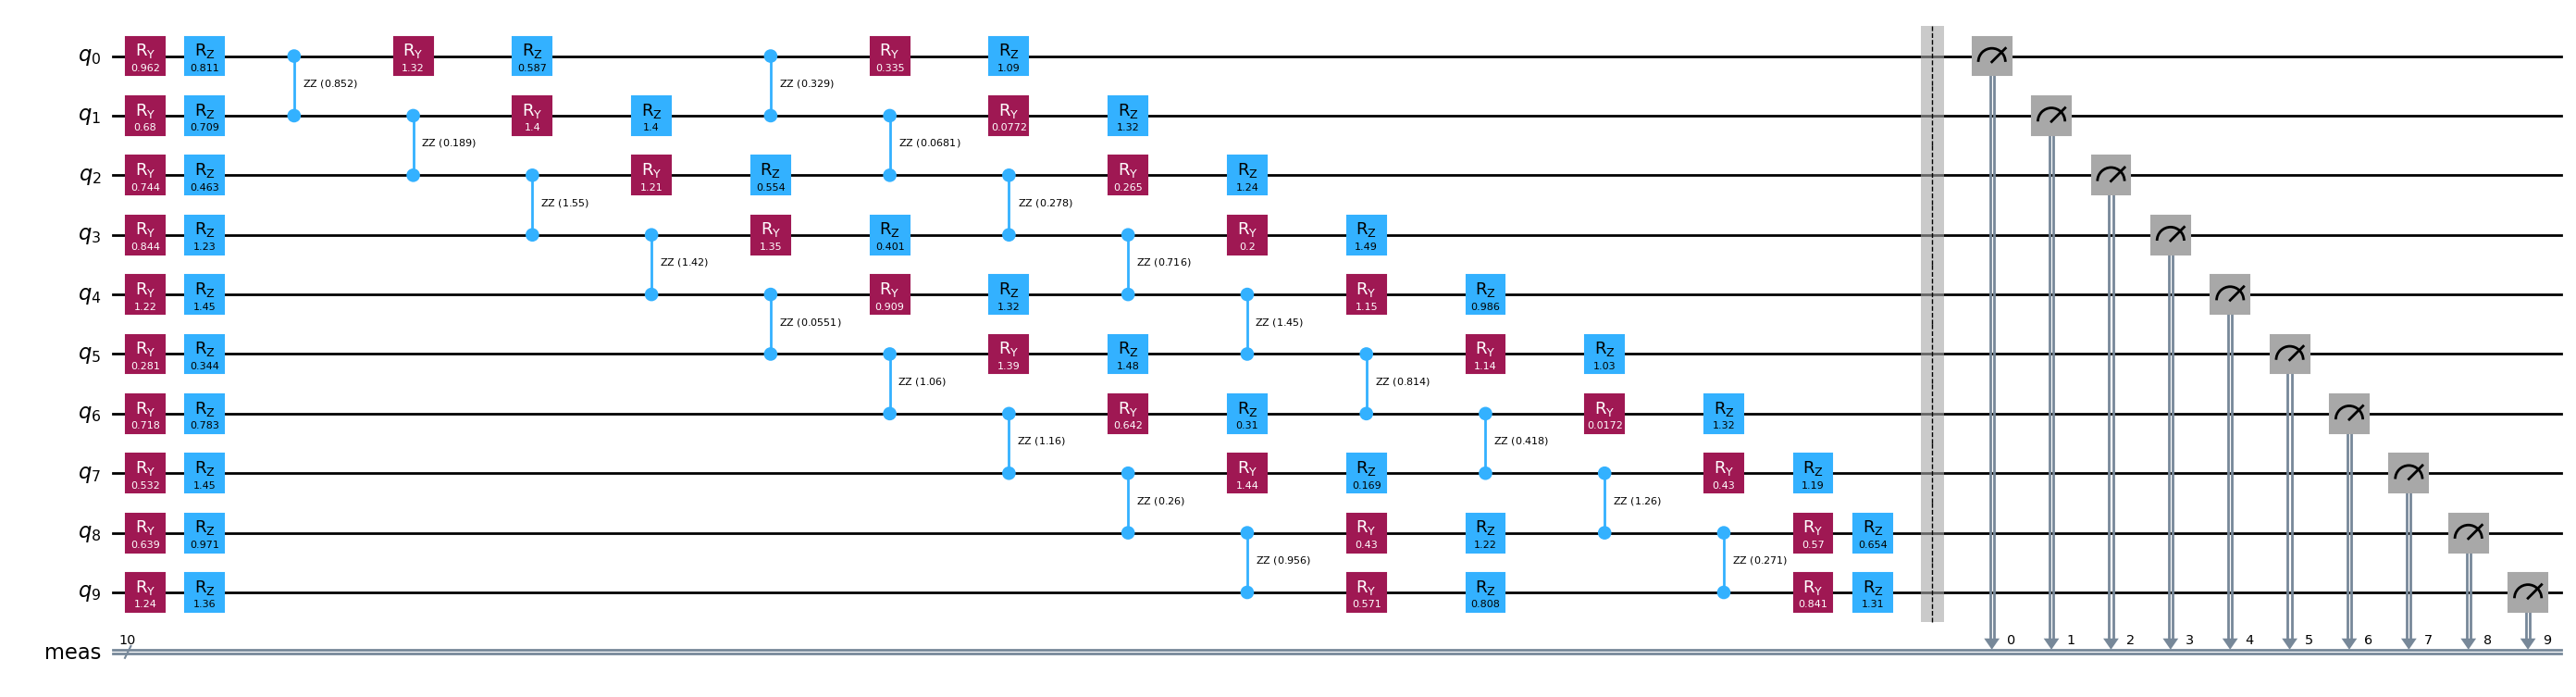

In [3]:
N = 10
circuit = TwoLocal(N, ["ry", "rz"], "rzz", entanglement="linear", reps=2).decompose()
circuit = circuit.assign_parameters(
    {param: np.random.rand() * np.pi / 2 for param in circuit.parameters}
)

from qiskit.circuit.random import random_circuit

circuit.measure_all()

circuit.draw("mpl", fold=-1)

  0%|          | 0/50 [00:00<?, ?it/s]

True


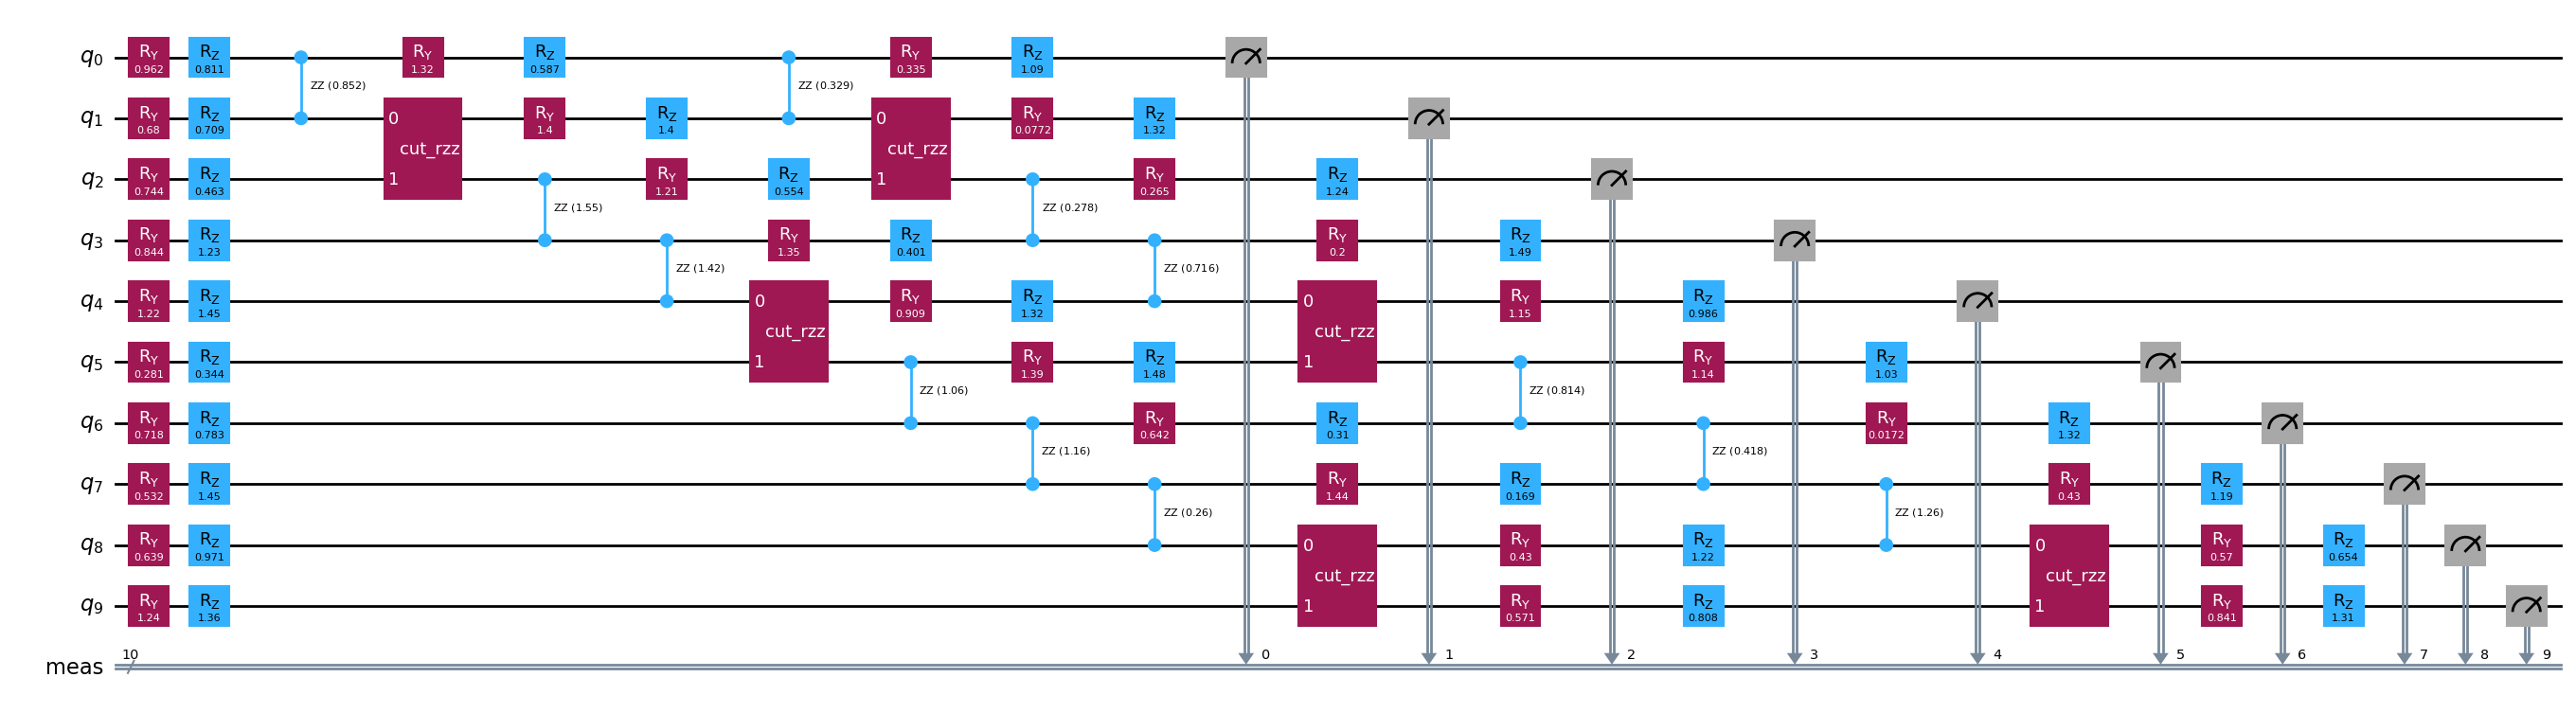

In [11]:
from qtpu.compiler.terminators import reach_num_qubits

cut_circuit = qtpu.cut(
    circuit,
    terminate_fn=reach_num_qubits(6),
    max_cost=1000,
    compression_methods=["qubits"],
    show_progress_bar=True,
    n_trials=50,
)
cut_circuit.draw("mpl", fold=-1)

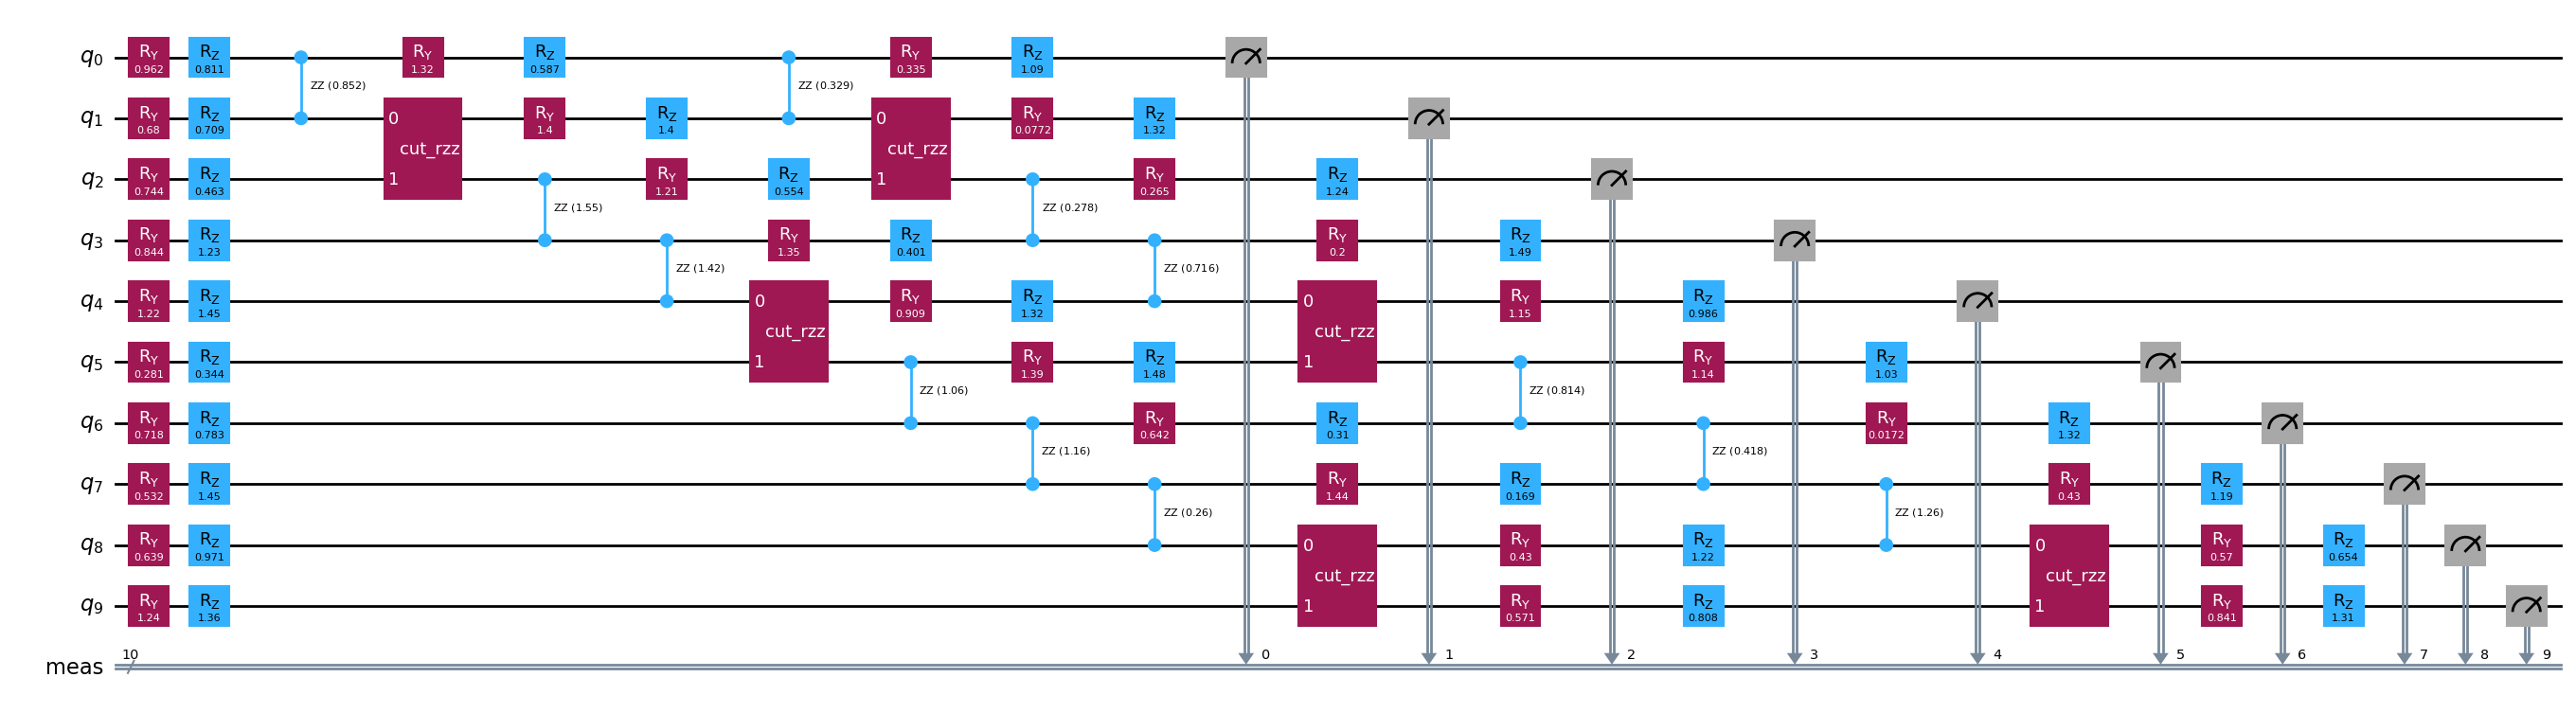

In [12]:
from qtpu.circuit import circuit_to_hybrid_tn, cuts_to_moves


cut_circuit = cuts_to_moves(cut_circuit)

# cut_circuit = wire_cuts_to_move(cut_circuit)

cut_circuit.draw('mpl', fold=-1)    
# print(htn)

# htn.quimb_tn().draw()

# from qtpu.contract2 import contract

# contract(htn)

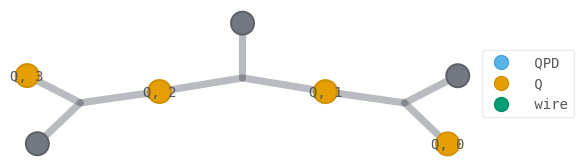

2736


In [13]:
htn = circuit_to_hybrid_tn(cut_circuit)
tn = htn.to_tensor_network()
tn.draw(color=["QPD", "Q", "wire"])
print(tn.contraction_cost(optimize='auto'))

In [14]:
from qtpu.contract import contract
from qiskit_aer.primitives import EstimatorV2


from qiskit_aer import AerSimulator

back = AerSimulator(device="GPU")


res = contract(htn, EstimatorV2())


Evaluating 2664 circuits


In [8]:
from qiskit.primitives import Sampler, Estimator


ref_circ = circuit.copy()
ref_circ.remove_final_measurements()
ref_expval = Estimator().run(ref_circ, ["Z" * N]).result().values[0]

print(f"Error: {abs(ref_expval - res)}")

# print(hellinger_fidelity(ref_samples, res.nearest_probability_distribution()))

Error: 2.905661822261152e-17


In [9]:
from qiskit.primitives import Sampler, Estimator
from qiskit.quantum_info import hellinger_fidelity

ref_samples = Sampler().run(circuit, shots=1000000).result().quasi_dists[0]

ref_circ = circuit.copy()
ref_circ.remove_final_measurements()
ref_expval = Estimator().run(ref_circ, ["Z" * N]).result().values[0]

print("Fidelities:")
print(ref_expval, res)
print(hellinger_fidelity(ref_samples, res.nearest_probability_distribution()))
# print(1 - abs(ref_expval - result_exp))

Fidelities:
-0.002956233014912402 -0.002956233014912431


AttributeError: 'float' object has no attribute 'nearest_probability_distribution'